<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>

Author: Jakub Pyszniak

# Data - introduction

**The Brazilian E-commerce dataset from the [Olist](https://www.olist.com/) store is sourced from [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv). This is a huge dataset of orders (around 100 000 entries) from 2016 to 2018 organised by the following schema (image from Kaggle).**

**Important notes about the dataset (from Kaggle):**
* "This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses."
* "An order might have multiple items."
* "Each item might be fulfilled by a distinct seller."

We will comment on other limitations of the data or the necessary understanding of the variables as they are analysed as part of EDA.

**We will need to create our own dataset from the following files with variables of interest. Below is a short description for each of the files:**

* olist_customers_dataset - customer id and location information
* olist_geolocation_dataset - zip code, longitude, latitude (mapping, useful for spatial econometrics) 
* olist_order_items_dataset - order, product, and seller id, price and freight value (calculation of how items and freight value comprise the total order value)
* olist_order_payments_dataset - payment types
* olist_order_reviews_dataset - reviews (comments scores, and dates)
* olist_orders_dataset - order and customer id, important order dates (core dataset)
* olist_products_dataset - product category, weight, height etc.
* olist_sellers_dataset - seller location
* product_category_name_translation - English translation of the product category from the products dataset (mapping)


![data shcema from kaggle](images/data_schema.png)

# Libraries

We need to load the necessary libraries for our analysis

In [65]:
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=UserWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel

# GBM
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

# GBM Histogram
from sklearn.ensemble import HistGradientBoostingRegressor

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# LightGBM
import lightgbm as lgb

# CatBoost
from catboost import CatBoostRegressor

# XGBoostLSS
#from xgboostlss.model import *

# Loading the data

Firstly, we must load the data and do some preliminary cleaning. It is important to note that these csv files are organised in an SQL-like schema and contain identity keys. This will allow us to match different type of information to a given order between datasets. However, this also means that the number of actual features (useful for our analysis) in these files may be noticeably smaller than the number of columns.

In [66]:
df_customers = pd.read_csv("data/olist_customers_dataset.csv")
df_geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
df_order_items = pd.read_csv("data/olist_order_items_dataset.csv")
df_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
df_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("data/olist_orders_dataset.csv")
df_products = pd.read_csv("data/olist_products_dataset.csv")
df_sellers = pd.read_csv("data/olist_sellers_dataset.csv")
df_prod_translate = pd.read_csv("data/olist_sellers_dataset.csv")

## File structure

Let's analyse the structure of our files one by one

### df_customers

In [67]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Great, we see that we don't have any nulls

In [68]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Clarification from Kaggle: "**At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers that made repurchases at the store.** Otherwise you would find that each order had a different customer associated with."

In [69]:
df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

We see that **customer_id** is greater than **customer_unique_id** by about 3000. This means that only about 3000 orders were made by returning customers. Since, we want to <u>model delays in order transport we might just focus on the **customer_id**</u> and connect it to each order placed. It may be useful to construct a binary variable to indicate a returning customer however such a variable would be severly imbalanced (most did not make a repurchase).

**Customer_city** may be a bit overwhelming with its 4119 unique values as a candidate for a location categorical variable. However, **customer_state** might do the job far better.


### df_geolocation

### df_payments

In [70]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [71]:
df_payments['order_id'].nunique()

99440

exactly, so we have some orders appearing more than once --> why?


In [72]:
df_payments["payment_value"].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

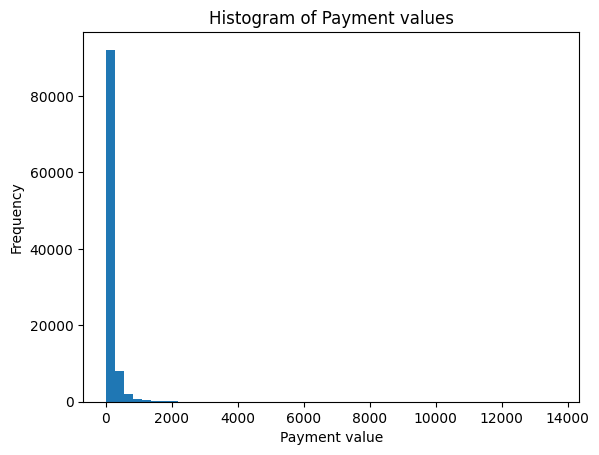

In [73]:
plt.hist(df_payments["payment_value"], bins=50)
plt.xlabel("Payment value")
plt.ylabel("Frequency")
plt.title("Histogram of Payment values")
plt.show()

In [ ]:
df_duplicates = df_payments[df_payments["order_id"].duplicated(keep=False)]
print(df_duplicates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7407 entries, 25 to 103874
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              7407 non-null   object 
 1   payment_sequential    7407 non-null   int64  
 2   payment_type          7407 non-null   object 
 3   payment_installments  7407 non-null   int64  
 4   payment_value         7407 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 347.2+ KB
None


In [92]:
df_duplicates.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
35,b2bb080b6bc860118a246fd9b6fad6da,1,credit_card,1,173.84
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
84,723e462ce1ee50e024887c0b403130f3,1,credit_card,1,13.80
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12


In [96]:
df_duplicates = df_duplicates.sort_values("order_id")
df_duplicates.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
10244,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00
16459,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4.50
15298,009ac365164f8e06f59d18a08045f6c4,6,voucher,1,4.17
32058,009ac365164f8e06f59d18a08045f6c4,4,voucher,1,5.45
285,009ac365164f8e06f59d18a08045f6c4,5,voucher,1,8.75


### df_orders

In [74]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


`not all orders got approved?`

`not all orders were delivered? -> do we analyse only those that were delivered? so we analsye the delay conditooinal on the order being delviered (at some point in time)`

Constructing our target variable - delay in order (in days) --> estimated delivery time is given in days anyways

In [75]:
df_orders_status_delivered = df_orders[df_orders["order_status"] == "delivered"].copy()
df_orders_status_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96478 non-null  object
 1   customer_id                    96478 non-null  object
 2   order_status                   96478 non-null  object
 3   order_purchase_timestamp       96478 non-null  object
 4   order_approved_at              96464 non-null  object
 5   order_delivered_carrier_date   96476 non-null  object
 6   order_delivered_customer_date  96470 non-null  object
 7   order_estimated_delivery_date  96478 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


In [76]:
df_orders_status_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [77]:
df_orders_status_delivered['order_delivered_customer_date'] = pd.to_datetime(df_orders_status_delivered['order_delivered_customer_date'])
df_orders_status_delivered['order_estimated_delivery_date'] = pd.to_datetime(df_orders_status_delivered['order_estimated_delivery_date'])

# Delay (in days) = actual date - estimated date (positive indicates a delay, negative indicates and earlier delivery)
df_orders_status_delivered["delay_days"] = (
    df_orders_status_delivered['order_delivered_customer_date']- df_orders_status_delivered['order_estimated_delivery_date']
).dt.days

In [78]:
df_orders_status_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  object        
 4   order_approved_at              96464 non-null  object        
 5   order_delivered_carrier_date   96476 non-null  object        
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  datetime64[ns]
 8   delay_days                     96470 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 7.4+ MB


We are losing some orders ->

from estimated to carrier ->2 lost
from carrier to sutomer ->6 lost

In [79]:
df_orders_status_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10.0


In [80]:
print(df_orders_status_delivered["delay_days"].describe())

print(df_orders_status_delivered["delay_days"].quantile([0.8, 0.85, 0.9, 0.95, 0.99, 0.995]))

count    96470.000000
mean       -11.875889
std         10.182105
min       -147.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
max        188.000000
Name: delay_days, dtype: float64
0.800    -6.0
0.850    -4.0
0.900    -2.0
0.950     3.0
0.990    18.0
0.995    27.0
Name: delay_days, dtype: float64


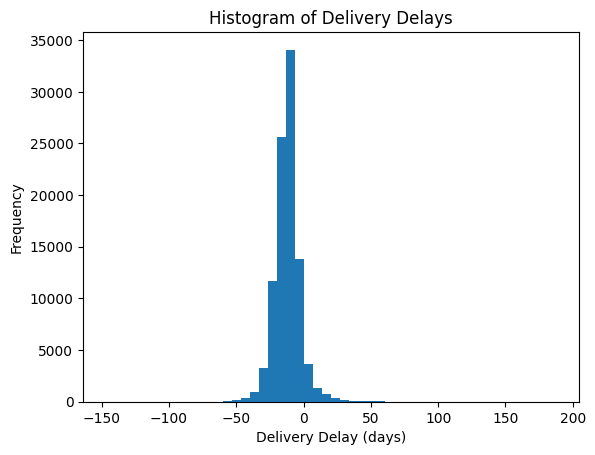

In [82]:
plt.hist(df_orders_status_delivered["delay_days"], bins=50)
plt.xlabel("Delivery Delay (days)")
plt.ylabel("Frequency")
plt.title("Histogram of Delivery Delays")
plt.show()

In [97]:
(df_orders_status_delivered["delay_days"] == 0).sum()

np.int64(1292)

In [98]:
(df_orders_status_delivered["delay_days"] > 0).mean() * 100


np.float64(6.77252845208234)

In [99]:
(df_orders_status_delivered["delay_days"] < 0).mean() * 100

np.float64(91.88001409647796)

In [101]:
(df_orders_status_delivered["delay_days"] == 0).mean() * 100

np.float64(1.3391654055846929)

In [102]:
(df_orders_status_delivered["delay_days"] > 0).mean() * 100 + (df_orders_status_delivered["delay_days"] < 0).mean() * 100 + (df_orders_status_delivered["delay_days"] == 0).mean() * 100

np.float64(99.991707954145)

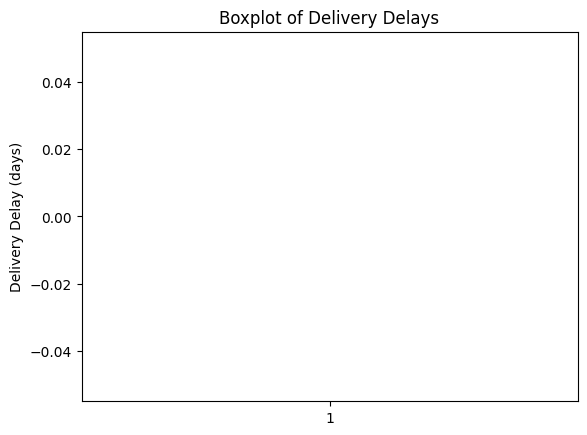

In [86]:
plt.boxplot(df_orders_status_delivered["delay_days"])
plt.ylabel("Delivery Delay (days)")
plt.title("Boxplot of Delivery Delays")
plt.show()